# Investment Assginment

In [1]:
# import required python libraries
import pandas as pd
import chardet
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# input file paths
companies_file = r".\data\companies.csv"
rounds2_file = r".\data\rounds2.csv"
mapping_file = r".\data\mapping.csv"

In [3]:
# find the file encoding for each file
def find_file_encoding(fname):
    r_file = open(fname, 'rb').read()
    result = chardet.detect(r_file)
    charenc = result['encoding']
    return charenc

find_file_encoding(rounds2_file)

# Companies file - 'Windows-1254'
# Rounds2 file - 'Windows-1254'
# mapping file - 'ascii'

'Windows-1254'

In [4]:
# Some error reading companies and rounds 2 file with 'Windows-1254', hence engine option is used
encoding1 = "ISO-8859-1"
companies = pd.read_csv(companies_file, engine= 'python')
rounds2 = pd.read_csv(rounds2_file, engine= 'python')

In [5]:
companies.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/Organization/0-6-Com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/Organization/004-Technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


In [6]:
rounds2.tail()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
114944,/organization/zzzzapp-com,/funding-round/8f6d25b8ee4199e586484d817bceda05,convertible_note,NaN,01-03-2014,41313.0
114945,/ORGANIZATION/ZZZZAPP-COM,/funding-round/ff1aa06ed5da186c84f101549035d4ae,seed,NaN,01-05-2013,32842.0
114946,/organization/ã�eron,/funding-round/59f4dce44723b794f21ded3daed6e4fe,venture,A,01-08-2014,NaN
114947,/ORGANIZATION/Ã”ASYS-2,/funding-round/35f09d0794651719b02bbfd859ba9ff5,seed,NaN,01-01-2015,18192.0
114948,/organization/ä°novatiff-reklam-ve-tanä±tä±m-h...,/funding-round/af942869878d2cd788ef5189b435ebc4,grant,NaN,01-10-2013,14851.0


# Checkpoint 1: Data Cleaning 1

In [7]:
# Use permalink as unique key for companies and rounds2
# Convert permalink to lower case
companies["permalink"] = companies["permalink"].apply(lambda x: x.lower())
rounds2["company_permalink"] = rounds2["company_permalink"].apply(lambda x: x.lower())

# Find unique companies in rounds2 
rounds2["permalink_encoded"] = rounds2["company_permalink"].apply(lambda x: x.encode('unicode_escape', 'strict'))
rounds2["permalink_encoded"].unique().shape

(66368,)

In [8]:
# Find unique companies in companies file 
companies["permalink_encoded"] = companies["permalink"].apply(lambda x: x.encode('unicode_escape', 'strict'))
companies["permalink_encoded"].unique().shape

(66368,)

In [9]:
# Find if there any companies in the rounds2 file which are not present in companies?
setC = set(companies["permalink_encoded"])
setR = set(rounds2["permalink_encoded"])
print(setC.difference(setR))
print(setR.difference(setC))

set()
set()


In [10]:
# Merge the two data frames
master_frame = pd.merge(rounds2, companies, on='permalink_encoded',how='left',suffixes=('_left','_right'))
master_frame.shape

(114949, 17)

# Checkpoint 2: Funding Type Analysis

In [11]:
# Spark Funds wants to choose one of these four investment types - seed, angel, venture and private_equity
df = master_frame[master_frame["funding_round_type"].isin(["seed", "angel", "venture", "private_equity"])]

# Remove rows having Null values
df = df[~df["raised_amount_usd"].isnull()]

# Spark Funds wants to invest between 5 to 15 million USD per investment round
# Remove outliers having funding value less than 500k and 150 Million
master_frame = df[((df["raised_amount_usd"] >= 5E5) & (df["raised_amount_usd"] <= 1.5E8))]

# Summary statistics
df_funding = master_frame[["company_permalink", "funding_round_type", "raised_amount_usd"]]
df_funding.groupby("funding_round_type").describe()

raised_amount_usd                                        \
                               count          mean           std       min   
funding_round_type                                                           
angel                         2229.0  1.646911e+06  3.006388e+06  500000.0   
private_equity                1610.0  3.598456e+07  3.902047e+07  500000.0   
seed                          9673.0  1.546603e+06  2.595150e+06  500000.0   
venture                      45216.0  1.094656e+07  1.524231e+07  500000.0   

                                                                     
                          25%         50%          75%          max  
funding_round_type                                                   
angel                653426.0   1000000.0   1633097.00   63590263.0  
private_equity      5968334.5  18382000.0  59755068.25  150000000.0  
seed                 747936.0   1100000.0   1880000.00  130000000.0  
venture             2400000.0   5817119.0  13000000.00  150000000.0

<AxesSubplot:title={'center':'raised_amount_usd'}, xlabel='[funding_round_type]'>

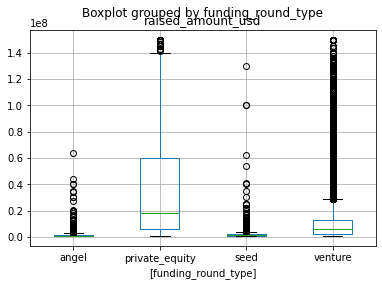

In [12]:
# Box and Whisker plot to visualize
df_funding.boxplot(by='funding_round_type')

### The most representative value of the investment amount is mean

### The most suitable investment type for Spark Funds is venture type funding

# Checkpoint 3: Country Analysis

In [13]:
# Remove rows having Null values for country_code
master_frame = master_frame[~master_frame["country_code"].isnull()]

# Filter the dataframe to have venture type funding details
df2 = master_frame[master_frame["funding_round_type"] == "venture"]

# Find the countries that have received the highest total funding
df3 = df2[["company_permalink", "country_code", "raised_amount_usd"]]
df4 = df3.groupby("country_code").sum().reset_index()
df4 = df4.sort_values(by="raised_amount_usd", ascending=False).reset_index()

# select top 9 countries that have received the highest total funding
top9 = df4.head(9)
top9.head(10)

,index,country_code,raised_amount_usd
0,91,USA,3.569427e+11
1,15,CHN,2.590326e+10
2,28,GBR,1.829193e+10
3,37,IND,1.079229e+10
4,12,CAN,9.386889e+09
5,40,ISR,6.903039e+09
6,27,FRA,6.524318e+09
7,20,DEU,6.172076e+09
8,43,JPN,2.888074e+09


### The top three English-speaking countries that received highest funding are USA, UK and India

# Checkpoint 4: Sector Analysis 1

In [14]:
# Remove rows having Null values for country_code
master_frame = master_frame[~master_frame["category_list"].isnull()]

# Extract the primary sector of each category list from the category_list column
master_frame["primary_sector"] = master_frame["category_list"].apply(lambda x: x if(x.find("|") == -1) else x[:x.find("|")])

# read mapping csv file
df_mapping = pd.read_csv(r"C:\Users\DataScience\data\Investment_Assignment\mapping.csv")
df_mapping = df_mapping[~df_mapping["category_list"].isnull()]

# fix spelling mistakes 0->na
df_mapping["category_list"] = df_mapping["category_list"].apply(lambda x: x if(x.find("0") == -1) else x.replace("0", "na"))
df_mapping["category_list"] = df_mapping["category_list"].apply(lambda x: x if(x.find(".na") == -1) else x.replace(".na", ".0"))
df_mapping["category_list"] = df_mapping["category_list"].apply(lambda x: x.lower())

# unpivot main sector columns
main_sector_list = ["Automotive & Sports", "Blanks", "Cleantech / Semiconductors", "Entertainment", "Health", "Manufacturing",
                    "News, Search and Messaging", "Others", "Social, Finance, Analytics, Advertising"]
df1 = pd.melt(df_mapping, id_vars=['category_list'], value_vars=main_sector_list, var_name='main_sector')

# select rows having 1 for value column
df1 = df1[df1["value"] == 1].reset_index()
#df1["category_list"].unique().shape

In [15]:
# map primary sector to main sector
def map_primary_to_mainsector(x):
    x=x.lower()
    if x in list(df1["category_list"]):
        index = df1[df1["category_list"]==x].index[0]
        return df1.iloc[index, 2]
    else:
        return "Not Present"
    

master_frame["main_sector"] = master_frame["primary_sector"].apply(map_primary_to_mainsector)

In [16]:
# Filter the primary sectors which are not listed in mapping.csv file
master_frame = master_frame[master_frame["main_sector"] != "Not Present"]
df2 = master_frame[["company_permalink", "primary_sector", "main_sector"]]
df2.head()

,company_permalink,primary_sector,main_sector
0,/organization/-fame,Media,Entertainment
2,/organization/-qounter,Application Platforms,"News, Search and Messaging"
4,/organization/0-6-com,Curated Web,"News, Search and Messaging"
8,/organization/0ndine-biomedical-inc,Biotechnology,Cleantech / Semiconductors
9,/organization/0xdata,Analytics,"Social, Finance, Analytics, Advertising"


# Checkpoint 5: Sector Analysis 2

## Create three separate data frames D1, D2 and D3 for each of the three countries containing the observations of funding type FT falling within the 5-15 million USD range

In [17]:
D1 = master_frame[((master_frame["country_code"]=="USA") & (master_frame["funding_round_type"]=="venture")
                  & (master_frame["raised_amount_usd"]>=5E6) & (master_frame["raised_amount_usd"]<=1.5E7))]

print("Country1 = USA")
print(D1["raised_amount_usd"].count())
print(D1["raised_amount_usd"].sum())

# Find the sectors that have received the highest total funding
df = D1[["name","main_sector"]]
df1 = df.groupby("main_sector").count().reset_index().rename(columns={'name':'count'})
df_sector_usa = df1.sort_values(by="count", ascending=False).reset_index()
df_sector_usa

Country1 = USA
12063
107757097294.0


,index,main_sector,count
0,6,Others,2950
1,7,"Social, Finance, Analytics, Advertising",2714
2,1,Cleantech / Semiconductors,2350
3,5,"News, Search and Messaging",1583
4,3,Health,909
5,4,Manufacturing,799
6,2,Entertainment,591
7,0,Automotive & Sports,167


In [18]:
# Company received highest funding in Others sector
df2 = D1[D1["main_sector"] == "Others"]
df2 = df2[["name","raised_amount_usd"]]
df2 = df2.groupby("name").sum().reset_index().rename(columns={'raised_amount_usd':'total_amount'})
df2 = df2.sort_values(by="total_amount", ascending=False).reset_index()
df2.head()

,index,name,total_amount
0,1877,Virtustream,64300000.0
1,313,Capella Photonics,54968051.0
2,57,AirTight Networks,54201907.0
3,1988,deCarta,52100000.0
4,221,Black Duck Software,51000000.0


In [19]:
# Company received highest funding in Social, Finance, Analytics, Advertising sector
df2 = D1[D1["main_sector"] == "Social, Finance, Analytics, Advertising"]
df2 = df2[["name","raised_amount_usd"]]
df2 = df2.groupby("name").sum().reset_index().rename(columns={'raised_amount_usd':'total_amount'})
df2 = df2.sort_values(by="total_amount", ascending=False).reset_index()
df2.head()

,index,name,total_amount
0,1321,SST Inc. (Formerly ShotSpotter),67933006.0
1,452,Demandbase,63000000.0
2,754,Intacct,61800000.0
3,1028,NetBase Solutions,60600000.0
4,890,Lotame,59700000.0


In [20]:
D2 = master_frame[((master_frame["country_code"]=="GBR") & (master_frame["funding_round_type"]=="venture")
                  & (master_frame["raised_amount_usd"]>=5E6) & (master_frame["raised_amount_usd"]<=1.5E7))]

print("Country2 = GBR")
print(D2["raised_amount_usd"].count())
print(D2["raised_amount_usd"].sum())

# Find the sectors that have received the highest total funding
df = D2[["name","main_sector"]]
df1 = df.groupby("main_sector").count().reset_index().rename(columns={'name':'count'})
df_sector_gbr = df1.sort_values(by="count", ascending=False).reset_index()
df_sector_gbr

Country2 = GBR
621
5379078691.0


,index,main_sector,count
0,6,Others,147
1,7,"Social, Finance, Analytics, Advertising",133
2,1,Cleantech / Semiconductors,130
3,5,"News, Search and Messaging",73
4,2,Entertainment,56
5,4,Manufacturing,42
6,3,Health,24
7,0,Automotive & Sports,16


In [21]:
# Company received highest funding in Others sector
df2 = D2[D2["main_sector"] == "Others"]
df2 = df2[["name","raised_amount_usd"]]
df2 = df2.groupby("name").sum().reset_index().rename(columns={'raised_amount_usd':'total_amount'})
df2 = df2.sort_values(by="total_amount", ascending=False).reset_index()
df2.head()

,index,name,total_amount
0,31,Electric Cloud,37000000.0
1,83,SenSage,36250000.0
2,32,Enigmatec,32500000.0
3,84,SilverRail Technologies,29000000.0
4,66,OpenCloud,27972766.0


In [22]:
# Company received highest funding in Social, Finance, Analytics, Advertising sector
df2 = D2[D2["main_sector"] == "Social, Finance, Analytics, Advertising"]
df2 = df2[["name","raised_amount_usd"]]
df2 = df2.groupby("name").sum().reset_index().rename(columns={'raised_amount_usd':'total_amount'})
df2 = df2.sort_values(by="total_amount", ascending=False).reset_index()
df2.head()

,index,name,total_amount
0,18,Celltick Technologies,37500000.0
1,101,myThings,34000000.0
2,94,Zopa,32900000.0
3,88,VisualDNA,28550000.0
4,44,MarketInvoice,25553007.0


In [23]:
D3 = master_frame[((master_frame["country_code"]=="IND") & (master_frame["funding_round_type"]=="venture")
                  & (master_frame["raised_amount_usd"]>=5E6) & (master_frame["raised_amount_usd"]<=1.5E7))]

print("Country3 = IND")
print(D3["raised_amount_usd"].count())
print(D3["raised_amount_usd"].sum())

# Find the sectors that have received the highest total funding
df = D3[["name","main_sector"]]
df1 = df.groupby("main_sector").count().reset_index().rename(columns={'name':'count'})
df_sector_ind = df1.sort_values(by="count", ascending=False).reset_index()
df_sector_ind

Country3 = IND
328
2949543602.0


,index,main_sector,count
0,6,Others,110
1,7,"Social, Finance, Analytics, Advertising",60
2,5,"News, Search and Messaging",52
3,2,Entertainment,33
4,4,Manufacturing,21
5,1,Cleantech / Semiconductors,20
6,3,Health,19
7,0,Automotive & Sports,13


In [24]:
# Company received highest funding in Others sector
df2 = D3[D3["main_sector"] == "Others"]
df2 = df2[["name","raised_amount_usd"]]
df2 = df2.groupby("name").sum().reset_index().rename(columns={'raised_amount_usd':'total_amount'})
df2 = df2.sort_values(by="total_amount", ascending=False).reset_index()
df2.head()

,index,name,total_amount
0,25,FirstCry.com,39000000.0
1,43,Myntra,38000000.0
2,15,CommonFloor,32900000.0
3,54,Pepperfry.com,28000000.0
4,35,ItzCash Card Ltd.,25000000.0


In [25]:
# Company received highest funding in Social, Finance, Analytics, Advertising sector
df2 = D3[D3["main_sector"] == "Social, Finance, Analytics, Advertising"]
df2 = df2[["name","raised_amount_usd"]]
df2 = df2.groupby("name").sum().reset_index().rename(columns={'raised_amount_usd':'total_amount'})
df2 = df2.sort_values(by="total_amount", ascending=False).reset_index()
df2.head()

,index,name,total_amount
0,28,Manthan Systems,50700000.0
1,25,Komli Media,28000000.0
2,38,ShopClues.com,25000000.0
3,46,inTarvo,21900000.0
4,21,Grameen Financial Services,21556050.0


# Checkpoint 6: Plots

### 1. A plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in each funding type. 

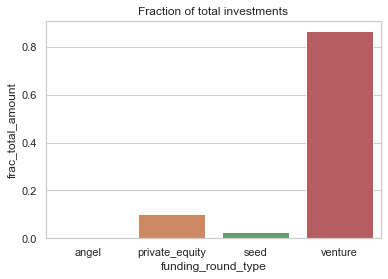

In [26]:
# Plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity
df_total = df_funding.groupby("funding_round_type").sum().reset_index().rename(columns={'raised_amount_usd':'total_amount'})
df_total["frac_total_amount"] = df_total["total_amount"]/df_total["total_amount"].sum()

sns.set(style="whitegrid")
sns.barplot(x="funding_round_type", y="frac_total_amount", data=df_total)
plt.title("Fraction of total investments")
plt.show()

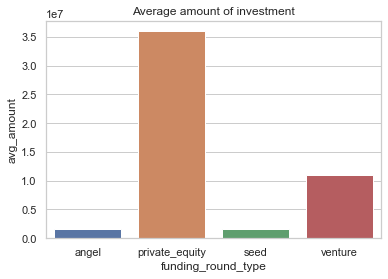

In [27]:
# Plot showing the average amount of investment in each funding type
df_avg = df_funding.groupby("funding_round_type").mean().reset_index().rename(columns={'raised_amount_usd':'avg_amount'})

sns.barplot(x="funding_round_type", y="avg_amount", data=df_avg)
plt.title("Average amount of investment")
plt.show()

### 2. A plot showing the top 9 countries against the total amount of investments of funding type FT. 

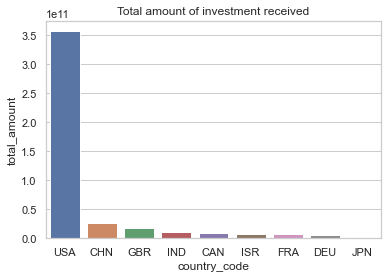

In [28]:
top9 = top9.rename(columns={'raised_amount_usd':'total_amount'})
sns.barplot(x="country_code", y="total_amount", data=top9)
plt.title("Total amount of investment received")
plt.show()

### A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). 

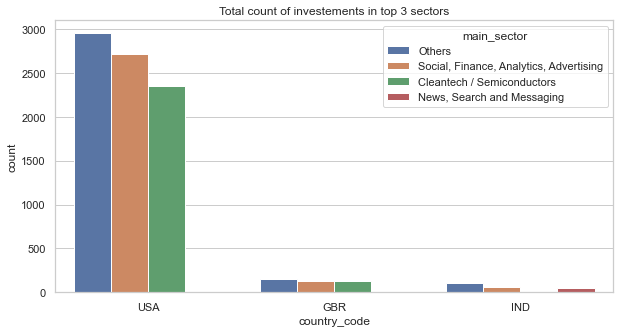

In [29]:
df_sector_usa = df_sector_usa[["main_sector", "count"]].head(3)
df_sector_usa["country_code"] = "USA"

df_sector_gbr = df_sector_gbr[["main_sector", "count"]].head(3)
df_sector_gbr["country_code"] = "GBR"

df_sector_ind = df_sector_ind[["main_sector", "count"]].head(3)
df_sector_ind["country_code"] = "IND"

df_concat = pd.concat([df_sector_usa, df_sector_gbr, df_sector_ind]).reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="country_code", y="count", hue = "main_sector", data=df_concat, ax=ax)
plt.title("Total count of investements in top 3 sectors")
plt.show()